# Presenting Uncertainty

In [110]:
import pandas as pd
import numpy as np
import json5
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import joblib
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import plotly.express as px

from quantile_dotplot import ntile_dotplot


In [111]:
#pip install git+https://github.com/ColCarroll/quantile_dotplot

# Goals
- [x] Load Out of Time Dataset and Model
- [x] Load Dot Plot Ratio
- [x] Run Dot Plot Predictor

## Set Run Specific Values
The dictionary below acts as a log for all the models built.

In [129]:
# Select model to use
run = 'model_run_13'

# Select Data Split
dataset_split = "oot" # "test" "oot"

# Open the Model Journal Document
with open('intermediate_data/04_model/modelJournal.json5', 'r') as json5_file:
    model_tests_dict = json5.load(json5_file)

# Gather list of features
feature_list_x = model_tests_dict[run]['feature_list_x']

# Gather actual y value
actual_y = model_tests_dict[run]['actual_y']

# Gather skus to filter out
filtered_sku_list = model_tests_dict[run]['ignore_sku_list']

# Gather scaling bool (True/False)
scale = model_tests_dict[run]['scale']

# Print information from model journal
pprint(model_tests_dict[run])

{'actual_y': 'y_actual_030',
 'feature_list_x': ['x_sales_last_002_days',
                    'x_sales_last_003_days',
                    'x_sales_last_005_days',
                    'x_sales_last_007_days',
                    'x_sales_last_014_days',
                    'x_sales_last_021_days',
                    'x_sales_last_030_days',
                    'x_sales_last_060_days',
                    'x_sales_last_090_days',
                    'x_sales_last_120_days',
                    'x_sales_last_150_days',
                    'x_sales_last_180_days',
                    'x_sales_last_210_days',
                    'x_sales_last_240_days',
                    'x_sales_last_270_days',
                    'x_sales_last_300_days',
                    'x_sales_last_300_days',
                    'x_sales_last_365_days',
                    'x_last_1_year_sales_001',
                    'x_last_1_year_sales_030',
                    'x_last_1_year_sales_060',
                    

## Load Test Dataset and Model

#### Load Test Dataset 

In [113]:
# Load full engineered dataset
df_engineered = pd.read_parquet("intermediate_data/03_analyze/engineerData.parquet")

# Filter down to split selected
df_engineered_split = df_engineered[(df_engineered['split']==dataset_split) & (~df_engineered['item_sku'].isin(filtered_sku_list))]

# Print dataset information
pprint("Dataset Shape: ", df_engineered_split.shape)
pprint("Number of SKU's: ", len(df_engineered_split['item_sku'].unique()))

# Display dataset
df_engineered_split.head()

Dataset Shape:  (1292830, 190)
Number of SKU's:  3542


,date,item_sku,total_units_sold,avg_price,itm,itm_active,itm_desc,itmde_discontinued,itmde_clutter,category_a,category_b,category_c,is_black,color,split,y_actual_030,y_actual_090,y_actual_150,x_sales_last_002_days,x_sales_last_003_days,x_sales_last_005_days,x_sales_last_007_days,x_sales_last_014_days,x_sales_last_021_days,x_sales_last_030_days,x_sales_last_060_days,x_sales_last_090_days,x_sales_last_120_days,x_sales_last_150_days,x_sales_last_180_days,y_simple_msr_030,y_simple_msr_090,y_simple_msr_150,y_legacy_msr_030,y_legacy_msr_090,y_legacy_msr_150,core_product,item_sku_cleaned,x_sales_last_210_days,x_sales_last_240_days,x_sales_last_270_days,x_sales_last_300_days,x_sales_last_330_days,x_sales_last_365_days,x_last_1_year_sales_001,x_last_1_year_sales_030,x_last_1_year_sales_060,x_last_1_year_sales_090,x_last_1_year_sales_120,x_last_1_year_sales_150,x_last_2_year_sales_001,x_last_2_year_sales_030,x_last_2_year_sales_060,x_last_2_year_sales_090,x_last_2_year_sales_120,x_last_2_year_sales_150,x_pf_sl060d_sl090d_1,x_pf_sl060d_sl090d_2,x_pf_sl060d_sl090d_3,x_pf_sl060d_sl090d_4,x_pf_sl060d_sl090d_5,x_pf_sl060d_sl014d_1,x_pf_sl060d_sl014d_2,x_pf_sl060d_sl014d_3,x_pf_sl060d_sl014d_4,x_pf_sl060d_sl014d_5,x_pf_sl060d_sl007d_1,x_pf_sl060d_sl007d_2,x_pf_sl060d_sl007d_3,x_pf_sl060d_sl007d_4,x_pf_sl060d_sl007d_5,x_pf_sl060d_l1ys150_1,x_pf_sl060d_l1ys150_2,x_pf_sl060d_l1ys150_3,x_pf_sl060d_l1ys150_4,x_pf_sl060d_l1ys150_5,x_pf_sl090d_sl014d_1,x_pf_sl090d_sl014d_2,x_pf_sl090d_sl014d_3,x_pf_sl090d_sl014d_4,x_pf_sl090d_sl014d_5,first_date_units_sold,x_days_from_launch,x_month_01_jan,x_month_02_feb,x_month_03_mar,x_month_04_apr,x_month_05_may,x_month_06_jun,x_month_07_jul,x_month_08_aug,x_month_09_sep,x_month_10_oct,x_month_11_nov,x_month_12_dec,x_category_a_PART,x_category_a_ACCESSORY,x_category_a_APPAREL,x_category_b_DERAILLEUR,x_category_b_HEADSET,x_category_b_WHEEL,x_category_b_MISC SMALL PARTS,x_category_b_CRANKSET,x_category_b_GRIP,x_category_b_BAG,x_category_b_CASSETTE/FREEWHEEL,x_category_b_SEATPOST,x_category_b_CHAIN,x_category_b_MISC,x_category_b_TOP,x_category_b_SOCKS/BOOTIES,x_category_b_HANDLEBAR,x_category_b_MISC SMALL ACCESSORY,x_category_b_HEADWARE,x_category_b_BOTTLES/DRINKCUPS,x_category_b_AXLE,x_category_b_TOOL,x_category_b_WATER BOTTLE CAGES,x_category_b_SHIFTERS,x_category_b_BELLS/HORNS,x_category_b_GLOVE,x_category_b_HANDLEBAR TAPE,x_category_b_LUBE/CLEANING,x_category_b_PEDAL,x_category_b_BEARING,x_category_b_FRAME/FORK,x_category_b_PUMPS/INFLATION,x_category__1-ALL,x_category__-CAP,x_category__-CUP,x_category__-RMIS,x_category__-QR,x_category__-FT,x_category__-NUT,x_category__REMOTE-,x_category__SC-,x_category__SP-,x_category__STRATA-,x_category__WF-,x_category__TLV-,x_category__8-BIT,x_category__AL-SS-,x_category__B-RAD,x_category__CUSTOM,x_category__ECHO-,x_category__ENCASE-,x_category__MATRIX,x_category__GNARWOLF-,x_category__OVAL-,x_category__SPACER,x_category__STEM,x_category__STRADA,x_category__ZS,x_category__digitMM,x_category__ECdigit,x_category__ISdigit,x_category__ZSdigit,x_color_BLACK,x_color_ORANGE,x_color_RED,x_color_GREY,x_color_BLUE,x_color_GREEN,x_color_YELLOW,x_color_PURPLE,x_color_WHITE,x_color_PINK,x_color_BROWN,x_color_RAINBOW,x_color__-RED,x_color__-BLK,x_color__-PRP,x_color__-ORG,x_color__-GRN,x_color__-GLD,x_color__-BLU,x_color__-GRY,x_color__-ESP,x_color__-PNK,x_color__-TEAL,x_color__-RBW,x_color__-OLV,x_color__-SIL,x_color__-RSIL,x_color__-NI,x_avg_price,x_race_regis_005,x_race_regis_030,x_race_regis_090,x_race_regis_365
7764904,2023-01-01,10S-Glink,0.0,16.630274,3993,True,"10S-GLINK, Assy,Derailleur Hanger Extension,Go...",False,False,PART,DERAILLEUR,link,BLACK,-99997,oot,178.0,331.0,799.0,0.0,0.0,1.0,1.0,31.0,48.0,58.0,150.0,226.0,353.0,406.0,564.0,58.0,226.0,406.0,77.971805,233.915414,389.859023,True,10S-GLINK,684.0,778.0,963.0,1127.0,1189.0,1430.0,0.0,182.0,303.0,460.0,618.0,734.0,1.0,292.0,704.0,1386.0,1782.0,2296.0,150.0,226.0,22500.0,33900.0,51076.0,150.0,31.0,22500.0,4650.0,961.0,150.0,1

## Scale Dataset (If Needed)

In [59]:
if scale:
    print("Scaling!")
    scaler_filename = "intermediate_data/04_model/scalers/scaler_{}.save".format(run)
    scaler = joblib.load(scaler_filename)
    df_engineered_split[data_list] = scaler.transform(df_engineered_split[data_list])
    print(scaler.data_max_[0])

Scaling!


/var/folders/8g/jlrtpx1n399fg_s05cw0352c0000gn/T/ipykernel_60694/3469495202.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_engineered_oot[data_list] = scaler.transform(df_engineered_oot[data_list])


2202.0


['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_reset',
 '_sklearn_auto_wrap_output_keys',
 '_validate_data',
 '_validate_params',
 'clip',
 'copy',
 'data_max_',
 'data_min_',
 'data_range_',
 'feature_names_in_',
 'feature_range',
 '

#### Load Item SKU List (Should not be needed)

In [105]:
# item_core_sku_list = df_engineered_oot[df_engineered_oot["core_product"]==True]["item_sku"].unique().tolist()

#### Load Model

In [114]:
mod = joblib.load('intermediate_data/04_model/models/{}.pkl'.format(run))

#### Generate Prediction

In [115]:
df_engineered_split.loc[:, 'pred'] = mod.predict(df_engineered_split[data_list])

/Users/betaops/git/bikemesh-bikecast-mvp-01/.conda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/var/folders/8g/jlrtpx1n399fg_s05cw0352c0000gn/T/ipykernel_60694/1298985124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_engineered_split.loc[:, 'pred'] = mod.predict(df_engineered_split[data_list])


## Run Quantile Dotplot Function

#### Load Dot Plot Ratio

In [116]:
with open('intermediate_data/dotPlotRatio.json', 'r') as json_file:
    sku_dotplot_ratio_dict = json.load(json_file)

#### Set Up Dot Plot Ratio

In [120]:
sku_specific = "10S-Glink" # 'MtbBarBagLEFT' #

def dotplot_sku_function(df , sku, sku_ratio_dict):
    data = np.array(sku_ratio_dict[sku])
    date_latest = df['date'].max()
    prediction = df[(df["item_sku"]== sku) & (df["date"]==date_latest)]['pred'].iloc[0]
    dotplotdata = prediction * data

    dotplt = ntile_dotplot(dotplotdata, dots=20, hist_bins="auto")
    print(type(dotplt))
    dotplt.axvline(x=prediction, color='r', linestyle='--', linewidth=2, label='Prediction')
    dotplt.set_title("30 Day Sales Prediction for {} on {} ".format(sku, date_latest))
    dotplt.set_xlabel("Units Sold in Next 30 Days")

#### Test Dot Plot Ratio Function

<class 'matplotlib.axes._axes.Axes'>


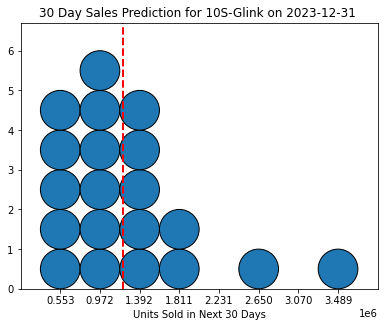

In [121]:
dotplot_sku_function(df_engineered_split, sku_specific, sku_dotplot_ratio_dict)

In [126]:
df_engineered_split[df_engineered_split["item_sku"] == sku_specific]

,date,item_sku,total_units_sold,avg_price,itm,itm_active,itm_desc,itmde_discontinued,itmde_clutter,category_a,category_b,category_c,is_black,color,split,y_actual_030,y_actual_090,y_actual_150,x_sales_last_002_days,x_sales_last_003_days,x_sales_last_005_days,x_sales_last_007_days,x_sales_last_014_days,x_sales_last_021_days,x_sales_last_030_days,x_sales_last_060_days,x_sales_last_090_days,x_sales_last_120_days,x_sales_last_150_days,x_sales_last_180_days,y_simple_msr_030,y_simple_msr_090,y_simple_msr_150,y_legacy_msr_030,y_legacy_msr_090,y_legacy_msr_150,core_product,item_sku_cleaned,x_sales_last_210_days,x_sales_last_240_days,x_sales_last_270_days,x_sales_last_300_days,x_sales_last_330_days,x_sales_last_365_days,x_last_1_year_sales_001,x_last_1_year_sales_030,x_last_1_year_sales_060,x_last_1_year_sales_090,x_last_1_year_sales_120,x_last_1_year_sales_150,x_last_2_year_sales_001,x_last_2_year_sales_030,x_last_2_year_sales_060,x_last_2_year_sales_090,x_last_2_year_sales_120,x_last_2_year_sales_150,x_pf_sl060d_sl090d_1,x_pf_sl060d_sl090d_2,x_pf_sl060d_sl090d_3,x_pf_sl060d_sl090d_4,x_pf_sl060d_sl090d_5,x_pf_sl060d_sl014d_1,x_pf_sl060d_sl014d_2,x_pf_sl060d_sl014d_3,x_pf_sl060d_sl014d_4,x_pf_sl060d_sl014d_5,x_pf_sl060d_sl007d_1,x_pf_sl060d_sl007d_2,x_pf_sl060d_sl007d_3,x_pf_sl060d_sl007d_4,x_pf_sl060d_sl007d_5,x_pf_sl060d_l1ys150_1,x_pf_sl060d_l1ys150_2,x_pf_sl060d_l1ys150_3,x_pf_sl060d_l1ys150_4,x_pf_sl060d_l1ys150_5,x_pf_sl090d_sl014d_1,x_pf_sl090d_sl014d_2,x_pf_sl090d_sl014d_3,x_pf_sl090d_sl014d_4,x_pf_sl090d_sl014d_5,first_date_units_sold,x_days_from_launch,x_month_01_jan,x_month_02_feb,x_month_03_mar,x_month_04_apr,x_month_05_may,x_month_06_jun,x_month_07_jul,x_month_08_aug,x_month_09_sep,x_month_10_oct,x_month_11_nov,x_month_12_dec,x_category_a_PART,x_category_a_ACCESSORY,x_category_a_APPAREL,x_category_b_DERAILLEUR,x_category_b_HEADSET,x_category_b_WHEEL,x_category_b_MISC SMALL PARTS,x_category_b_CRANKSET,x_category_b_GRIP,x_category_b_BAG,x_category_b_CASSETTE/FREEWHEEL,x_category_b_SEATPOST,x_category_b_CHAIN,x_category_b_MISC,x_category_b_TOP,x_category_b_SOCKS/BOOTIES,x_category_b_HANDLEBAR,x_category_b_MISC SMALL ACCESSORY,x_category_b_HEADWARE,x_category_b_BOTTLES/DRINKCUPS,x_category_b_AXLE,x_category_b_TOOL,x_category_b_WATER BOTTLE CAGES,x_category_b_SHIFTERS,x_category_b_BELLS/HORNS,x_category_b_GLOVE,x_category_b_HANDLEBAR TAPE,x_category_b_LUBE/CLEANING,x_category_b_PEDAL,x_category_b_BEARING,x_category_b_FRAME/FORK,x_category_b_PUMPS/INFLATION,x_category__1-ALL,x_category__-CAP,x_category__-CUP,x_category__-RMIS,x_category__-QR,x_category__-FT,x_category__-NUT,x_category__REMOTE-,x_category__SC-,x_category__SP-,x_category__STRATA-,x_category__WF-,x_category__TLV-,x_category__8-BIT,x_category__AL-SS-,x_category__B-RAD,x_category__CUSTOM,x_category__ECHO-,x_category__ENCASE-,x_category__MATRIX,x_category__GNARWOLF-,x_category__OVAL-,x_category__SPACER,x_category__STEM,x_category__STRADA,x_category__ZS,x_category__digitMM,x_category__ECdigit,x_category__ISdigit,x_category__ZSdigit,x_color_BLACK,x_color_ORANGE,x_color_RED,x_color_GREY,x_color_BLUE,x_color_GREEN,x_color_YELLOW,x_color_PURPLE,x_color_WHITE,x_color_PINK,x_color_BROWN,x_color_RAINBOW,x_color__-RED,x_color__-BLK,x_color__-PRP,x_color__-ORG,x_color__-GRN,x_color__-GLD,x_color__-BLU,x_color__-GRY,x_color__-ESP,x_color__-PNK,x_color__-TEAL,x_color__-RBW,x_color__-OLV,x_color__-SIL,x_color__-RSIL,x_color__-NI,x_avg_price,x_race_regis_005,x_race_regis_030,x_race_regis_090,x_race_regis_365,pred
7764904,2023-01-01,10S-Glink,0.0,16.630274,3993,True,"10S-GLINK, Assy,Derailleur Hanger Extension,Go...",False,False,PART,DERAILLEUR,link,BLACK,-99997,oot,178.0,331.0,799.0,0.0,0.0,1.0,1.0,31.0,48.0,58.0,150.0,226.0,353.0,406.0,564.0,58.0,226.0,406.0,77.971805,233.915414,389.859023,True,10S-GLINK,684.0,778.0,963.0,1127.0,1189.0,1430.0,0.0,182.0,303.0,460.0,618.0,734.0,1.0,292.0,704.0,1386.0,1782.0,2296.0,150.0,226.0,22500.0,33900.0,51076.0,150.0,31.0,22500.0,4650.0,961.0,15

In [127]:
1.063148e+06

1063148.0

In [106]:
#incomplete_sku = []
#for key, value in sku_dotplot_ratio_dict.items() :
#    if key in item_core_sku_list:
#        if len(value)==0:
#            incomplete_sku.append(key)
#        elif len(value) > 365:
#            print(key)
#    #print(len(value))


In [107]:
len(incomplete_sku)

242

In [109]:
sku_dotplot_ratio_dict["AXLE15-100-FX-BLU"]

[]

In [108]:
incomplete_sku

['BB3028',
 '12038',
 'OVAL6428',
 'OVAL6430',
 'RFC28',
 'XTR9636',
 'OVAL-SDM32',
 'OVAL-BB3028',
 'BB3036',
 '10234',
 '11-KMCX11SLDLCBLK',
 'REMOTE-LA-CLMP',
 'OVAL-EAST42',
 'SST-SS-COG20',
 'AXLE15-100-FX-BLU',
 'AXLE15-100-FX-RED',
 'AXLE15-100-SR-BLU',
 'AXLE15-150-SR-RED',
 'AXLE15-100-RD-BLU',
 'AXLE15-100-RD-RED',
 'AXLE15-100-SR-RED',
 'AXLE15-100-SR-PRP',
 'AXLE15-100-FX-PRP',
 'AXLE15-100-SR-ORG',
 'AXLE15-150-SR-PRP',
 'AXLE15-110-SR-GRN',
 'CAMO-BLUBOLT',
 'XTR9634-SH12',
 'ERC40-FT',
 'OVAL-SH11044',
 'ELP-CAMO-AL34-SH12',
 'F-AXLE12-120-150-PRP',
 'F-AXLE12-125-150-BLU',
 'F-AXLE12-125-150-ORG',
 'F-AXLE12-125-150-PRP',
 'F-AXLE12-125-150-RED',
 'STEMCAP5MMNI',
 'F-AXLE12-120-150-ORG',
 'F-AXLE12-120-150-GRN',
 'F-AXLE12-122-175-RED',
 'REMOTE-LA-CLMP-NI',
 'REMOTE-CLMP-NI',
 'F-AXLE12-120-150-BLU',
 '11052-FT',
 'F-AXLE12-122-175-BLU',
 'F-AXLE12-122-175-ORG',
 'F-AXLE12-122-175-PRP',
 'F-AXLE12-120-150-RED',
 'SUSTAIN-A-BASE',
 'BTL-ECHO-BLK-22oz-M',
 'BTL-MATRIX-BL

In [96]:
len(sku_dotplot_ratio_dict["BB3028"])

0

In [94]:
np.array(sku_dotplot_ratio_dict["BB3028"])

array([], dtype=float64)

In [66]:
pd.set_option('display.max_columns', None)


1211634.0

In [72]:


df_engineered_oot[df_engineered_oot["item_sku"] == "5-9430"][['date', 'item_sku', 'pred']]

,date,item_sku,pred
7764930,2023-01-01,5-9430,2.977820
7768474,2023-01-02,5-9430,2.978519
7772018,2023-01-03,5-9430,2.979218
7775562,2023-01-04,5-9430,2.979917
7779106,2023-01-05,5-9430,2.980616
...,...,...,...
9040770,2023-12-27,5-9430,0.519734
9044314,2023-12-28,5-9430,0.520433
9047858,2023-12-29,5-9430,0.521132
9051402,2023-12-30,5-9430,0.521831


In [73]:
np.array(sku_dotplot_ratio_dict["5-9430"])

array([], dtype=float64)

## Run Interactive Dot Plot Function

In [132]:
interactive_widget = interact_manual(
    dotplot_sku_function,
    df=fixed(
        df_engineered_oot
        ),
    sku=widgets.Combobox(
        value='10S-Glink',
        placeholder='Choose SKU',
        options=item_sku_list,
        description='Item SKU:',
        ensure_option=True,
        disabled=False
    ),
    sku_ratio_dict = fixed(
        sku_dotplot_ratio_dict
        )
);

# Display the widget
display(interactive_widget)

interactive(children=(Combobox(value='10S-Glink', continuous_update=False, description='Item SKU:', ensure_opt…

<function __main__.dotplot_sku_function(df, sku, sku_ratio_dict)>

- [ ] Historic Macro's 
- [ ] Save history of Macros from Brad
- [ ] Remove "1-" attributes